<a href="https://colab.research.google.com/github/Johnsylva/100-days-of-code/blob/master/Time_Series_air_passenger_forecast_arima_sarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## TIME SERIES PROJECT
BY
DAVID ABIMBOLA  A00737175 &
OGBEIDE UWAGBOE A00785715 

##TIME SERIES ANALYSIS FOR AIR PASSENGERS

###ABSTRACT

Air passenger data is a data of air travellers in the united states, classified in date/time and the passengers travelling per month. The aim is to predict the number of passengers travelling using time series data. Airlines need to be able to know what the likelihood of passenger traffic would be so they can be able to plan for maintenance of airplanes, availabilty of airplanes and air workers as well. That way they can better serve their customers. With the use of observations of passenger traffic in the past and present month, we employed time series model to forecast the demand for airplanes.

###INTRODUCTION

Time series analysis accounts for the fact that data points taken over time may have an internal structure (such as autocorrelation, trend, or seasonal variation) that should be accounted for. Time series analysis is applicable in many fields, such as business, economics, and retail, because sales, prices, and currency are not constant over time. For this project, we will focus on a time series analysis of air passenger data to be able to focast the number of air passengers for the future using the past and present month data of air passengers.

Predicting air passengers is an important topic in airline business and travel economy which has spured the interest of airline companies to develop better predictive models to accommodate in their business model. Though we have sophisticated machine learning models to predict/forcast a time sensitive/dynamic datasets, since the correlations between variables is time sensitive and the model has to train design algorithms based upon data relation form consecutive timestamp ARIMA model has an upper edge to handle time series datasets as it has a functionality of auto regression which most of the machine learning algorithms lack of. 

###DATASET

The dataset used for this project was obtained from https://www.kaggle.com/code/rezaadiguna/air-passengers-time-series/data

The AirPassenger dataset provides monthly totals of a US airline passengers, from 1949 to 1960. This dataset is already of a time series class therefore no further class or date manipulation is required.The data set contains two columns( Month and Passengers)


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


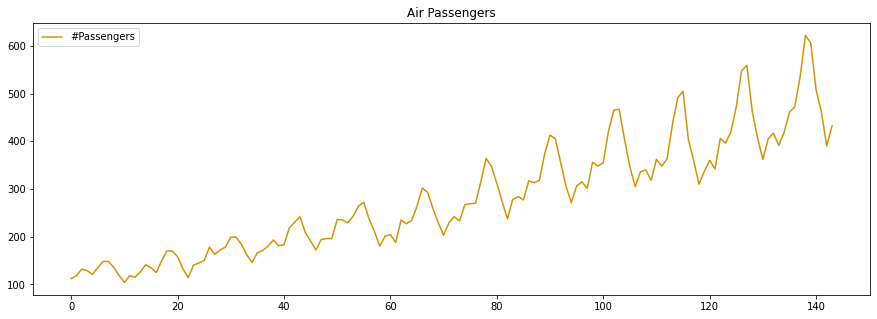

In [65]:
data = pd.read_csv("/AirPassengers.csv")
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

data.plot(style='-', figsize=(15,5), color=color_pal[1], title="Air Passengers")
plt.show()



##TIME SERIES MODEL ANALYSIS

### Import the Necessary Libraries : 

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [74]:
data.head()


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Data Info :

In [75]:
data.shape

(144, 2)

In [76]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


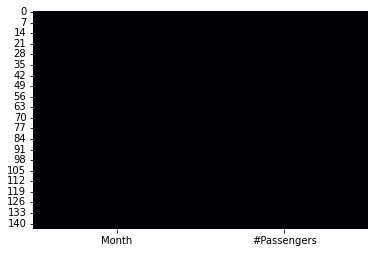

In [78]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

- **No null values** present in the data!

In [79]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [80]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Converting the datatype of the **Month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **Month** to **Date** and **#Passengers** to **Passengers** as well.
- It is a monthly distributed data.

# <center>Time Series Analysis</center>

### Supportive Functions for Time Series Analysis :

In [81]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [82]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Components of Time Series :
- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
    E.g : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
    E.g : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
    E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
    E.g : Occurrences of Earthquakes or Floods, etc.
    
    
- **In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.** 

Let's visualize the **Passengers** data for the above components!
- For this purpose, we use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

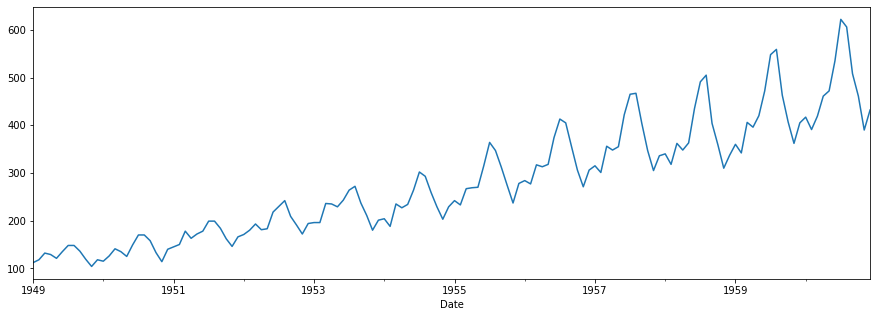

In [83]:
plt.figure(figsize = (15,5))
data['Passengers'].plot();

- From the above graph of **Passengers** data, we can say that it represents a **Multiplicative Model** as the data has increasing width & height of the peaks.
- Let us decompose the multiple components of the **Passengers** time series.

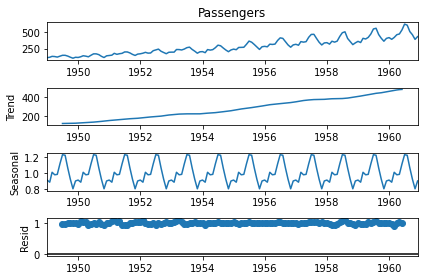

In [84]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

- Data clearly has a **linear uptrend**.
- A clear cut **seasonal** pattern of a 1 year duration is present in the data.
- We also need to check the statistical parameters w.r.t time. 

### Stationarity :

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical parameters will change values over time as they are extracted from the features.
- If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
- Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.
- To test stationarity, we will use **Augmented Dickey Fuller Test** : 
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, then the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **#Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected and accepting that the time series is stationary, there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

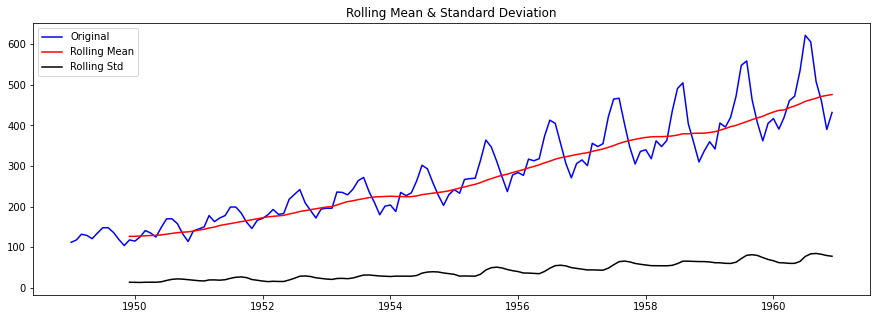

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [85]:
test_stationarity(data['Passengers'])

- For the **Passengers** time series data, 
    - **Rolling Mean** is clearly variable with time. 
    - **Rolling Standard Deviation** is has some crests - troughs that vary according to the time.
    - **Test Statistic : (0.82)** > **Critical Value (5%) : (-2.88)**
    - **p-value (0.99)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above **Passengers** time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value. We will work on log values of the data from here!

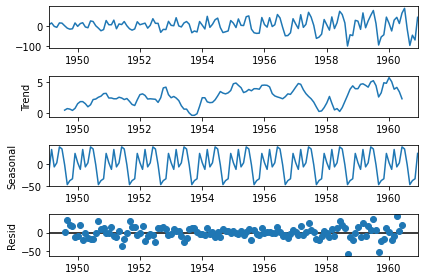

In [86]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

- We have taken the **log** of the data to deal with **stationarity** and **differencing** is done to handle **trend** and **seasonality**.
- **Trend** of the data has near about died down & their values have been reduced as well. However, **Seasonality** of the data is clearly visible.
- We now check the **stationarity** of the time series.

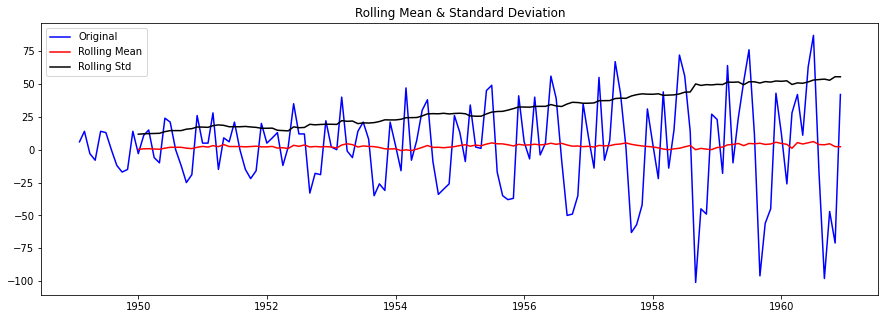

Results of Dickey-Fuller Test:
Test Statistic                 -2.83
p-value                         0.05
#Lags Used                     12.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [87]:
test_stationarity(data_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** displays a slight uptrend over time.
    - **Test Statistic : (-2.83)** > **Critical Value (5%) : (-2.88)**. 
    - **p-value (0.05)** > **0.05**
- From the above values, we will use the above time series despite it just fails on the **stationarity** test.
- Effect of **double-differencing** would be too heavy on the data and might result in poor performance.

# <center>Modeling</center>

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

- **ARIMA** model is a combination of 3 models :
    - **AR (p) : Auto Regressive**
    - **I (d) : Integrated**
    - **MA (q) : Moving Average**

- **(p,d,q)** is known as the order of the **ARIMA** model. Values of these parameters are based on the above mentioned models.  
    - **p** : Number of auto regressive terms. 
    - **d** : Number of differencing orders required to make the time series stationary.
    - **q** : Number of lagged forecast errors in the prediction equation.

- Selection criteria for the order of **ARIMA** model : 
    - **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
    - **d** : Number of times differencing is carried out to make the time series stationary.
    - **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

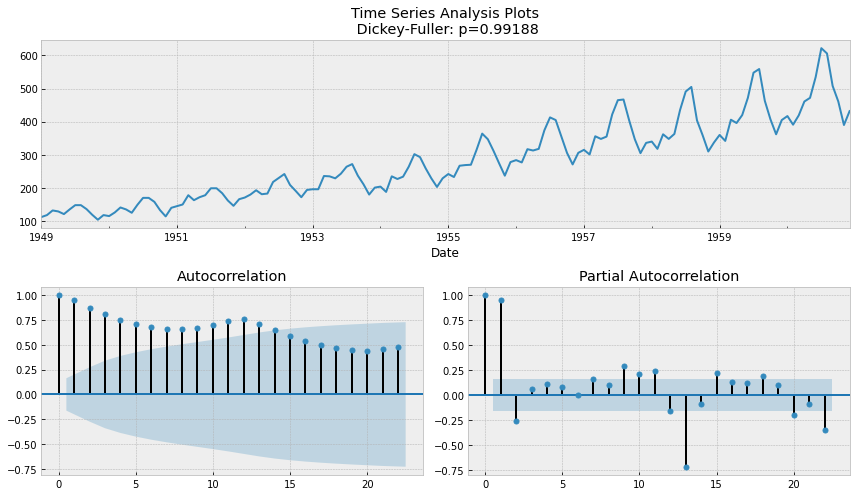

In [115]:
tsplot(data['Passengers'])

- **ACF** graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- **PACF** graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.
- From the **PACF** graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the **ACF** graph where the next lag follows it's previous lag.

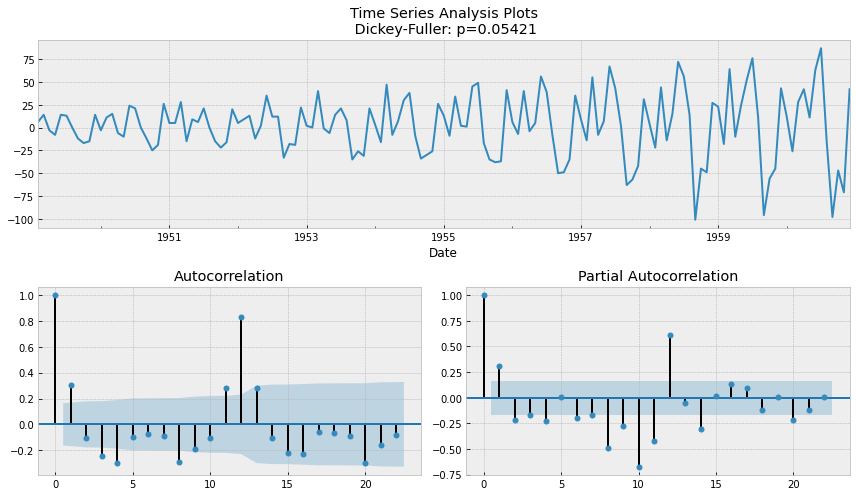

In [116]:
tsplot(data_diff['Passengers'])

- From the above plots, the following order of **ARIMA** model is selected from the selection criteria mentioned above :
    - **p** : 2
    - **d** : 1
    - **q** : 2
- The data passed for model fitting is the **Log_Passengers** data that is non-differenced data and non-stationary data.
- In order to make the series stationary, we difference the time series. Thus, this differencing of data is carried out by the ARIMA model with the help of the **d** parameter that provides info about the order of differencing.
- Thus, the parameters **p** and **q** are selected in such a way that we pass their values assuming the ARIMA model carries out the differencing process and makes the time series stationary.

In [117]:
model = ARIMA(data['Passengers'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.716
Date:                Thu, 08 Dec 2022   AIC                           1344.043
Time:                        04:07:20   BIC                           1361.821
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Passengers     1.6477      0.033     49.931      0.000       1.583       1.712
ar.L2.D.Passengers  

### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [118]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted = 433.257207, expected = 491.000000
predicted = 478.356321, expected = 505.000000
predicted = 474.552588, expected = 404.000000
predicted = 367.686879, expected = 359.000000
predicted = 386.045459, expected = 310.000000
predicted = 300.551696, expected = 337.000000
predicted = 342.709379, expected = 360.000000
predicted = 374.434365, expected = 342.000000
predicted = 368.418712, expected = 406.000000
predicted = 427.293838, expected = 396.000000
predicted = 416.580536, expected = 420.000000
predicted = 431.952388, expected = 472.000000
predicted = 465.574838, expected = 548.000000
predicted = 516.133904, expected = 559.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 522.642258, expected = 463.000000
predicted = 407.122824, expected = 407.000000
predicted = 367.581749, expected = 362.000000
predicted = 349.941720, expected = 405.000000
predicted = 415.817559, expected = 417.000000
predicted = 443.407923, expected = 391.000000
predicted = 432.877343, expected = 419.000000
predicted = 467.788410, expected = 461.000000
predicted = 505.288675, expected = 472.000000
predicted = 505.208303, expected = 535.000000
predicted = 548.677930, expected = 622.000000
predicted = 603.214773, expected = 606.000000
predicted = 560.807472, expected = 508.000000
predicted = 458.423398, expected = 461.000000
predicted = 419.513522, expected = 390.000000
predicted = 373.834421, expected = 432.000000


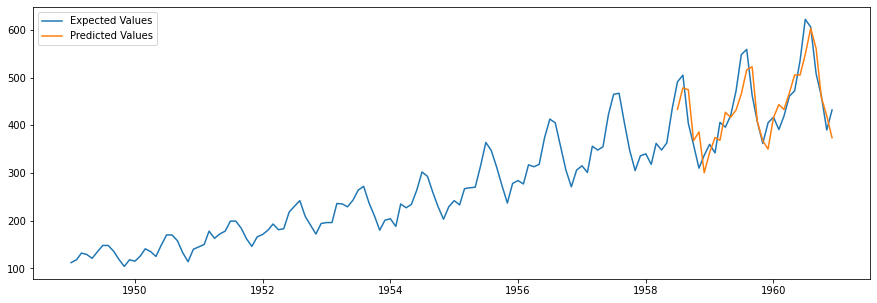

In [119]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- **Predicted Values** and **Expected Values** are very close.

In [120]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 42.5181


- Test RMSE value is quite high.
- Presence of seasonality as well as order of the **ARIMA** model might have had an effect on the model performance. We will move on to **Out - Of - Sample Forecasting**.

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **rolling** method by using **forecast function** and **predict function**.
- In the **rolling** method, we forecast or predict the next single value, use this predicted value again for model fitting that is then used for predicting the next value.

In [121]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


- We create 2 new columns for storing the values forecasted or predicted into **ARIMA_Forecast_Function** and **ARIMA_Predict_Function**.

#### Forecast Function : 

In [122]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()[0][0]
    
    ARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[144 + i,1] = f1[i]
forecast.tail()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,490.80,NaN
1961-10-12,NaN,493.31,NaN
1961-10-19,NaN,495.81,NaN
1961-10-26,NaN,498.32,NaN
1961-11-02,NaN,500.83,NaN


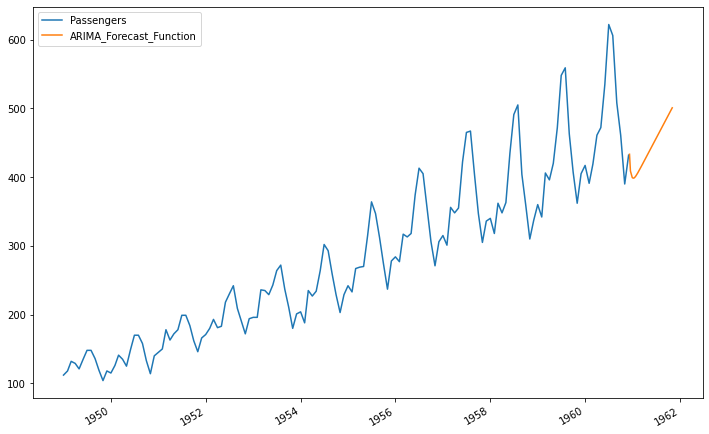

In [123]:
forecast[['Passengers','ARIMA_Forecast_Function']].plot(figsize = (12,8));

- Values generated by the **forecast_function** are rising. The model clearly did not understand the seasonal patterns of the data.

#### Predict Function :

In [124]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[144 + i,2] = f2[i]
forecast.tail()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,490.80,490.80
1961-10-12,NaN,493.31,493.31
1961-10-19,NaN,495.81,495.81
1961-10-26,NaN,498.32,498.32
1961-11-02,NaN,500.83,500.83


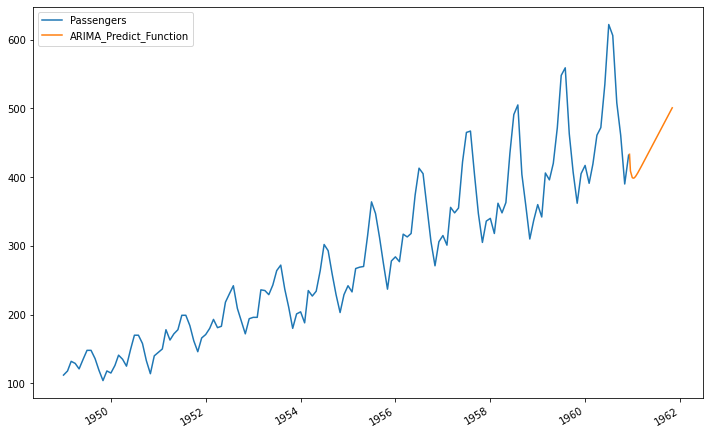

In [125]:
forecast[['Passengers','ARIMA_Predict_Function']].plot(figsize = (12,8));

- Similar pattern can be observed for the values generated by the **predict_function**. 
- Let's compare the values generated by the **forecast_function** and **predict_function**.

In [126]:
sum(f1) == sum(f2)

True

- For the above trained **ARIMA** model, values generated by **forecast_function** and **predict function** are either exactly identical or just differ by a few decimal points!
- The model clearly did not capture the **seasonal patterns** of the data.

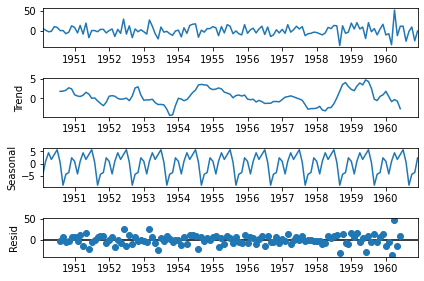

In [127]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**. 
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model. 
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model. 
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M** and check the **PACF** & **ACF** values at the **Mth** lag value. 

- Our data is in **monthly format** and the **seasonal period is of 1 year**.
- Hence, we difference the already differenced data by a periodicity, **M**, value of 12.
- The seasonality of the data has not completely died down but it's values have been dropped.
- We will check this seasonal differenced data for stationarity.

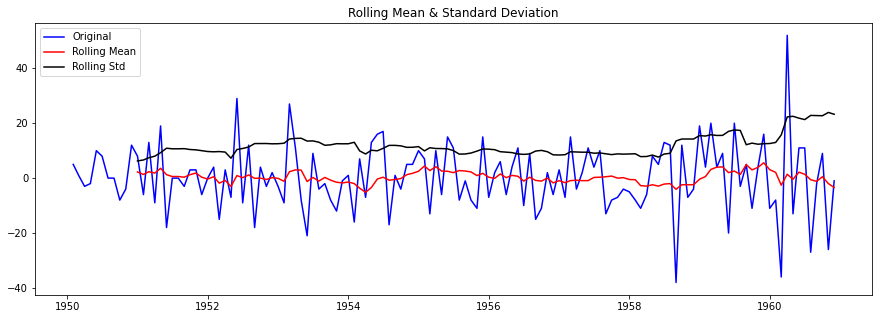

Results of Dickey-Fuller Test:
Test Statistic                -15.60
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [128]:
test_stationarity(data_diff_seas['Passengers'])

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** is near about constant with certain crests - troughs present throughout.
    - **Critical Value (5%) : (-2.88)** > **Test Statistic : (-15.60)**. We can say that the time series is **stationary with 99%** confidence as the **Test Statistic** is less than **Critical Value (1%)** as well.
    - **0.05** > **p-value (0.00)**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**.

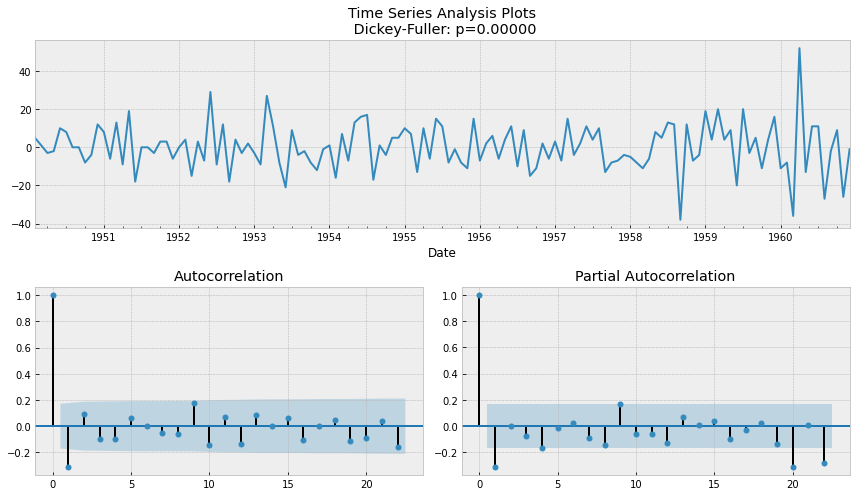

In [129]:
tsplot(data_diff_seas['Passengers'])

- For the **SARIMA** model, order of **(p,d,q)** will be same as the order of the **ARIMA** model above. 
- For **(P,D,Q,M)** :
    - **P** : 0
    - **D** : 1
    - **Q** : 1
    - **M** : 12

In [130]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Thu, 08 Dec 2022   AIC                           1019.935
Time:                                      04:10:01   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset similar to the approach of **ARIMA** model.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [131]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 479.083943, expected = 491.000000
predicted = 490.553509, expected = 505.000000
predicted = 441.276123, expected = 404.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 357.273139, expected = 359.000000
predicted = 315.250905, expected = 310.000000
predicted = 347.832938, expected = 337.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 344.249304, expected = 360.000000
predicted = 336.836110, expected = 342.000000
predicted = 387.592045, expected = 406.000000
predicted = 387.333487, expected = 396.000000
predicted = 408.192790, expected = 420.000000
predicted = 485.988159, expected = 472.000000
predicted = 529.031344, expected = 548.000000
predicted = 551.914009, expected = 559.000000
predicted = 459.061273, expected = 463.000000
predicted = 411.970100, expected = 407.000000
predicted = 358.421152, expected = 362.000000
predicted = 384.945729, expected = 405.000000
predicted = 420.143844, expected = 417.000000
predicted = 397.755392, expected = 391.000000
predicted = 451.335525, expected = 419.000000
predicted = 415.675162, expected = 461.000000
predicted = 465.295951, expected = 472.000000
predicted = 529.835409, expected = 535.000000
predicted = 599.299657, expected = 622.000000
predicted = 626.292198, expected = 606.000000
predicted = 513.891978, expected = 508.000000
predicted = 450.136743, expected =

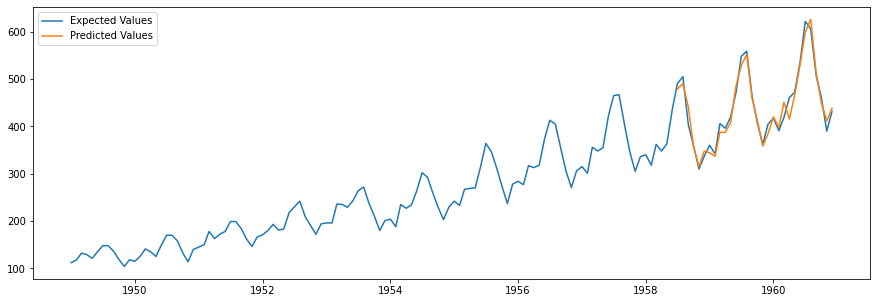

In [132]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- The above trained **SARIMA model** has performed quite well in forecasting in - sample values

In [133]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9253


- Test RMSE value is ok!

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **non-rolling** method by using **forecast function** and **predict function**.
- In the **non-rolling** method, we forecast or predict all future values at once. We store these future values into 2 new columns **SARIMA_Forecast_Function** and **SARIMA_Predict_Function** in the existing forecast dataframe.

In [134]:
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN,NaN


#### Forecast Function :

In [135]:
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[144 + i,3] = f3[i]
forecast.tail()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,490.80,490.80,423.79,NaN
1961-10-12,NaN,493.31,493.31,469.38,NaN
1961-10-19,NaN,495.81,495.81,456.60,NaN
1961-10-26,NaN,498.32,498.32,471.07,NaN
1961-11-02,NaN,500.83,500.83,542.69,NaN


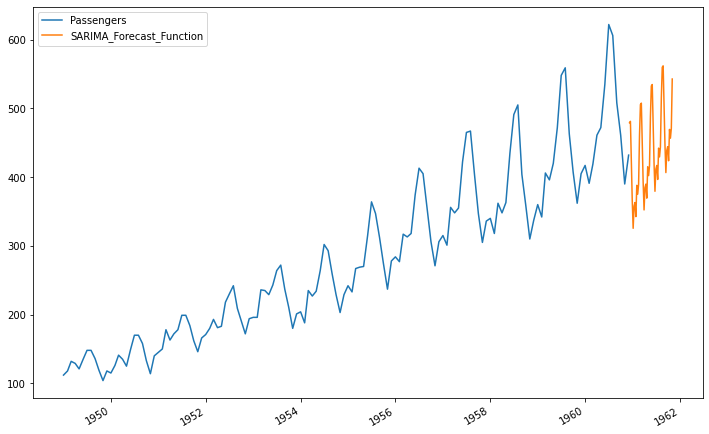

In [136]:
forecast[['Passengers','SARIMA_Forecast_Function']].plot(figsize = (12,8));

- From the above graph, we can say that **SARIMA** model understood the trend, seasonal pattern but it did not understand the increasing width of the seasonal pattern that is a characteristic feature of a **multiplicative** model.

#### Predict Function :

In [137]:
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(SARIMA_history_p),end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[144 + i,4] = f4[i]
forecast.tail()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,490.80,490.80,423.79,423.79
1961-10-12,NaN,493.31,493.31,469.38,469.38
1961-10-19,NaN,495.81,495.81,456.60,456.60
1961-10-26,NaN,498.32,498.32,471.07,471.07
1961-11-02,NaN,500.83,500.83,542.69,542.69


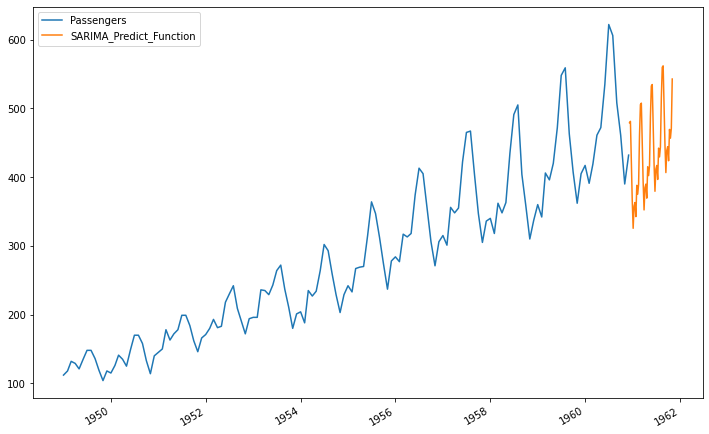

In [138]:
forecast[['Passengers','SARIMA_Predict_Function']].plot(figsize = (12,8));

- **SARIMA_Predict_Function** graph displays a similar pattern as the **SARIMA_Forecast_Function**.

In [139]:
sum(f3) == sum(f4)

True

- Values of **SARIMA_Predict_Function** and **SARIMA_Forecast_Function** are identical or slightly different.

GARCH

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.

Specifically, the model includes lag variance terms (e.g. the observations if modeling the white noise residual errors of another process), together with lag residual errors from a mean process.

The introduction of a moving average component allows the model to both model the conditional change in variance over time as well as changes in the time-dependent variance. Examples include conditional increases and decreases in variance.

As such, the model introduces a new parameter “p” that describes the number of lag variance terms:

p: The number of lag variances to include in the GARCH model.
q: The number of lag residual errors to include in the GARCH model.
A generally accepted notation for a GARCH model is to specify the GARCH() function with the p and q parameters GARCH(p, q); for example GARCH(1, 1) would be a first order GARCH model.

A GARCH model subsumes ARCH models, where a GARCH(0, q) is equivalent to an ARCH(q) model.

In [140]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 907 kB 4.7 MB/s 


In [146]:
import pmdarima
import arch
from arch import arch_model

am = arch_model(data)
res = am.fit(update_freq=5)
print(res.summary())
#fit ARIMA on returns 
arima_model_fitted = pmdarima.auto_arima(data)





/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.429e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      5,   Func. Count:     27,   Neg. LLF: 854.7268354995242
Iteration:     10,   Func. Count:     56,   Neg. LLF: 842.2560282989048
Iteration:     15,   Func. Count:     82,   Neg. LLF: 840.6224190409685
Iteration:     20,   Func. Count:    107,   Neg. LLF: 840.5352921203864
Optimization terminated successfully    (Exit mode 0)
            Current function value: 840.5335350535536
            Iterations: 23
            Function evaluations: 121
            Gradient evaluations: 23
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Passengers   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -840.534
Distribution:                  Normal   AIC:                           1689.07
Method:            Maximum Likelihood   BIC:                           1700.95
                            

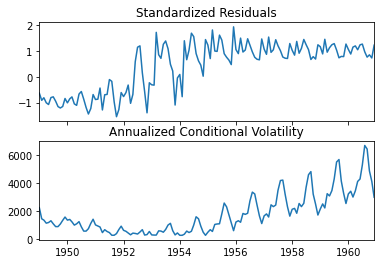

In [147]:
fig = res.plot(annualize="D")

In [148]:
# one-step out-of sample forecast
garch_forecast = res.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
predicted_et

/usr/local/lib/python3.8/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


202.3970476440798

##CONCLUSION

From the above trained ARIMA model, values generated are either exactly identical or just differ by a few decimal points. However, the ARIMA model did not capture the seasonal patterns of the data. 

From the test RMSE of 16.9, it is safe to say that the trained SARIMA model has performed quite well in forecasting in-sample values. Hence, we can say that the SARIMA model understood the trend, seasonal pattern but it did not understand the increasing width of the seasonal pattern that is a characteristic feature of a multiplicative model. It is also seen that the values of SARIMA_Predict_function and SARIMA forcast_function are identical or slightly different.

From the above result of the GARCH model, we can see that it provides a dynamic estimate of the volatility of the air passenger time series data and the conditional variances.

REFERENCES

https://www.kaggle.com/datasets/rakannimer/air-passengers?resource=download
http://rstudio-pubs-static.s3.amazonaws.com/311446_08b00d63cc794e158b1f4763eb70d43a.html
https://ieeexplore.ieee.org/document/9307571
https://github.com/Manishms18/Air-Passengers-Time-Series-Analysis#readme
https://towardsdatascience.com/arima-vs-prophet-forecasting-air-passenger-numbers-4e01b2d93608
https://www.researchgate.net/publication/268199171_Comparative_performance_of_ARIMA_and_ARCHGARCH_models_on_time_series_of_daily_equity_prices_for_large_companies
https://faculty.washington.edu/ezivot/econ589/ch18-garch.pdf
